In [1]:
import os, sys
import numpy as np
import json
import random
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import StepLR
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

## Preliminary

In [2]:
torch.manual_seed(12345)
k = 10000
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
na_list = ['A', 'C', 'G', 'T'] #nucleic acids
aa_list = ['R', 'L', 'S', 'A', 'G', 'P', 'T', 'V', 'N', 'D', 'C', 'Q', 'E', 'H', 'I', 'K', 'M', 'F', 'W', 'Y'] #amino acids
hydrophobicity = {'G': 0, 'A': 41, 'L':97, 'M': 74, 'F':100, 'W':97, 'K':-23, 'Q':-10, 'E':-31, 'S':-5, 'P':-46, 'V':76, 'I':99, 'C':49, 'Y':63, 'H':8, 'R':-14, 'N':-28, 'D':-55, 'T':13}
NNK_freq = [0.09375]*3 + [0.0625]*5 + [0.03125]*13 #freq of 21 NNK codons including the stop codon
sum_20 = 0.0625*5 + 0.09375*3 + 0.03125*12 #sum of freq without the stop codon
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*12 #normalize freq for 20 codons
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11 + \
        [1- sum([0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11)] 
        #adjust sum to 1 due to numerical issue
aa_dict = dict(zip(aa_list, pvals))

## Dataset

In [3]:
class BinaryDataset(Dataset):
    def __init__(self, filepath):
        def construct_binary_dataset(filepath):
            with open(filepath, 'r') as f:
                aptamer_data = json.load(f)
            ds = []
            for aptamer in aptamer_data:
                peptides = aptamer_data[aptamer]
                for peptide in peptides:
                    ds.append((aptamer, peptide, 1))
                    ds.append((get_x(), get_y(), 0))
            ds = list(set(ds)) #removed duplicates, random order
            return ds

        # Sample x from P_X (assume apatamers follow uniform)
        def get_x():
            x_idx = np.random.randint(0, 4, 40)
            x = ""
            for i in x_idx:
                x += na_list[i]
            return x

        # Sample y from P_y (assume peptides follow NNK)
        def get_y():
            y_idx = np.random.choice(20, 7, p=pvals)
            y = "M"
            for i in y_idx:
                y += aa_list[i]
            return y

        self.binary_ds=construct_binary_dataset(filepath)

    def __len__(self):
        return len(self.binary_ds)

    def __getitem__(self,idx):
        return(self.binary_ds[idx])

In [4]:
binary_ds=BinaryDataset(filepath="../data/aptamer_dataset.json")
n = len(binary_ds)
m = int(0.8*n) #length of train
binary_train = binary_ds[:m]
binary_val = binary_ds[m:]

## NN Model

In [5]:
class LinearNet(nn.Module):
    def __init__(self):
        super(LinearNet, self).__init__()
        self.name = "LinearNet"
        
        self.fc_apt_1 = nn.Linear(160, 100) 
        self.fc_apt_2 = nn.Linear(100, 50)
        self.fc_apt_3 = nn.Linear(50, 10)
        
        self.fc_pep_1 = nn.Linear(160, 50)
        self.fc_pep_2 = nn.Linear(50, 10)
        
        self.relu = nn.ReLU()
        
        self.fc_apt = nn.Sequential(self.fc_apt_1, self.fc_apt_2, self.fc_apt_3)
        self.fc_pep = nn.Sequential(self.fc_pep_1, self.fc_pep_2)
        
        self.fc1 = nn.Linear(20, 1)
        
    def forward(self, apt, pep):
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        apt = self.fc_apt(apt)
        pep = self.fc_pep(pep)
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x

In [6]:
class LinearConv1d(nn.Module):
    def __init__(self):
        super(LinearConv1d, self).__init__()
        self.name = "LinearConv1d"
        
        self.cnn_apt_1 = nn.Conv1d(4, 10, 3) 
        self.cnn_apt_2 = nn.Conv1d(10, 25, 3) 
        self.cnn_apt_3 = nn.Conv1d(25, 50, 3) 
        self.cnn_apt_4 = nn.Conv1d(50, 100, 1) 
        
        self.cnn_pep_1 = nn.Conv1d(20, 50, 3)
        self.cnn_pep_2 = nn.Conv1d(50, 100, 1)

        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(2) 
        
        self.cnn_apt = nn.Sequential(self.cnn_apt_1, self.maxpool, self.relu, 
                                     self.cnn_apt_2, self.maxpool, self.relu,
                                     self.cnn_apt_3, self.maxpool, self.relu,
                                     self.cnn_apt_4, self.maxpool, self.relu)
        self.cnn_pep = nn.Sequential(self.cnn_pep_1, self.maxpool, self.relu,
                                     self.cnn_pep_2, self.maxpool, self.relu)
        
        self.fc1 = nn.Linear(200, 200)
        self.fc2 = nn.Linear(200, 1)
    
    def forward(self, apt, pep):
        apt = apt.permute(0, 2, 1)
        pep = pep.permute(0, 2, 1)
        apt = self.cnn_apt(apt)
        pep = self.cnn_pep(pep)
        #print(apt.size())
        #print(pep.size())
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

In [7]:
class ConvNetSimple(nn.Module):
    def __init__(self):
        super(ConvNetSimple, self).__init__()
        self.name = "ConvNetSimple"
        
        self.cnn_apt_1 = nn.Conv1d(4, 500, 3) 
        self.cnn_apt_2 = nn.Conv1d(500, 250, 3)
        self.cnn_apt_3 = nn.Conv1d(250, 125, 3)
        self.cnn_apt_4 = nn.Conv1d(125, 50, 1)
        
        self.cnn_pep_1 = nn.Conv1d(20, 500, 3)
        self.cnn_pep_2 = nn.Conv1d(500, 250, 3)
        self.cnn_pep_3 = nn.Conv1d(250, 50, 1)
       
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2)         
        self.fc1 = nn.Linear(100, 1)
        
    def forward(self, apt, pep):
        # apt input size [1, 40, 4]
        apt = apt.permute(0, 2, 1)
        
        apt = self.pool1(self.relu(self.cnn_apt_1(apt)))
        #print("apt1: ", apt.size())
        apt = self.pool1(self.relu(self.cnn_apt_2(apt)))
        #print("apt2: ", apt.size())
        apt = self.pool1(self.relu(self.cnn_apt_3(apt)))
        #print("apt3: ", apt.size())
        apt = self.pool1(self.relu(self.cnn_apt_4(apt)))
        #print("apt4: ", apt.size()) (1, 50, 1)
        
        # pep input size [1, 8, 20]
        pep = pep.permute(0, 2, 1)

        pep = self.relu(self.cnn_pep_1(pep))
        #print("pep1: ", pep.size())
        pep = self.pool1(self.relu(self.cnn_pep_2(pep)))
        #print("pep2: ", pep.size())
        pep = self.pool1(self.relu(self.cnn_pep_3(pep)))
        #print("pep3: ", pep.size()) (1, 50, 1)
        
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        #print("cat: ", x.size())
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x

In [8]:
class ConvNetComplex(nn.Module):
    def __init__(self):
        super(ConvNetComplex, self).__init__()
        self.name = "ConvNetComplex"
        
        self.cnn_apt_1 = nn.Conv1d(4, 1000, 3) 
        self.cnn_apt_2 = nn.Conv1d(1000, 800, 3)
        self.cnn_apt_3 = nn.Conv1d(800, 600, 3)
        self.cnn_apt_4 = nn.Conv1d(600, 400, 3)
        self.cnn_apt_5 = nn.Conv1d(400, 200, 1)
        self.cnn_apt_6 = nn.Conv1d(200, 100, 1)
        
        self.cnn_pep_1 = nn.Conv1d(20, 1000, 3)
        self.cnn_pep_2 = nn.Conv1d(1000, 800, 1)
        self.cnn_pep_3 = nn.Conv1d(800, 500, 1)
        self.cnn_pep_4 = nn.Conv1d(500, 250, 1)
        self.cnn_pep_5 = nn.Conv1d(250, 100, 1)
        
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2)         
        self.fc1 = nn.Linear(200, 1)
        
    def forward(self, apt, pep):
        # apt input size [1, 40, 4]
        apt = apt.permute(0, 2, 1)
        
        apt = self.relu(self.cnn_apt_1(apt))
        apt = self.relu(self.cnn_apt_2(apt))
        apt = self.pool1(self.relu(self.cnn_apt_3(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_4(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_5(apt)))        
        apt = self.pool1(self.relu(self.cnn_apt_6(apt)))
        

        # pep input size [1, 8, 20]
        pep = pep.permute(0, 2, 1)
        
        pep = self.relu(self.cnn_pep_1(pep))
        pep = self.relu(self.cnn_pep_2(pep))
        pep = self.relu(self.cnn_pep_3(pep))
        pep = self.pool1(self.relu(self.cnn_pep_4(pep)))
        pep = self.pool1(self.relu(self.cnn_pep_5(pep)))
        
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x

In [9]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.zeros_(m.bias.data)
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='sigmoid')
        nn.init.zeros_(m.bias.data)

## Helper methods

In [10]:
## Takes a peptide and aptamer sequence and converts to one-hot matrix
def one_hot(sequence, seq_type='peptide'):
    if seq_type == 'peptide':
        letters = aa_list
    else:
        letters = na_list
    one_hot = np.zeros((len(sequence), len(letters)))
    for i in range(len(sequence)):
        char = sequence[i]
        for _ in range(len(letters)):
            idx = letters.index(char)
            one_hot[i][idx] = 1
    return one_hot

# Convert a pair to one-hot tensor
def convert(apt, pep, label): 
    apt = one_hot(apt, seq_type='aptamer') #(40, 4)
    pep = one_hot(pep, seq_type='peptide') #(8, 20)
    apt = torch.FloatTensor(np.reshape(apt, (-1, apt.shape[0], apt.shape[1]))).to(device) #(1, 40, 4)
    pep = torch.FloatTensor(np.reshape(pep, (-1, pep.shape[0], pep.shape[1]))).to(device) #(1, 8, 20)
    label = torch.FloatTensor([label]).to(device)
    return apt, pep, label

# Getting the output of the model for a pair (aptamer, peptide)
def update(x, y):
    x.requires_grad=True
    y.requires_grad=True
    x = x.to(device)
    y = y.to(device)
    out = model(x, y)
    return out

## Plotting functions
def plot_loss(iters, train_losses, val_losses, model_name):
    plt.title("Training Loss Curve")
    plt.plot(train_losses, label="Train")
    plt.plot(val_losses, label="Validation")
    plt.xlabel("%d Iterations" %iters)
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.savefig('plots/binary/%s/loss.png' %model_name, bbox_inches='tight')
    plt.show()

def plot_accuracy(iters, train_acc, val_acc, model_name):
    plt.title("Training Accuracy Curve")
    plt.plot(train_acc, label="Train")
    plt.plot(val_acc, label="Validation")
    plt.xlabel("%d Iterations" %iters)
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.savefig('plots/binary/%s/accuracy.png' %model_name, bbox_inches='tight')
    plt.show()

## Binary Classification

In [18]:
def classifier(model, 
               train, 
               val,
               num_epochs=50,
               batch_size=16,
               run_from_checkpoint=checkpoint, 
               save_checkpoints=save_path):
    
    if run_from_checkpoint is not None:
        checkpointed_model = run_from_checkpoint
        checkpoint = torch.load(checkpointed_model)
        optimizer = SGD(model.parameters(), lr=5e-3)
        model.load_state_dict(checkpoint['model_state_dict'])
        optim.load_state_dict(checkpoint['optimizer_state_dict'])
        init_epoch = checkpoint['epoch']
        print("Reloading model: ", model.name, " at epoch: ", init_epoch)
    else:
        model.apply(weights_init)
    
    train_losses, val_losses, train_losses_avg, val_losses_avg, train_acc, val_acc = [], [], [], [], [], []
    iters, train_correct, val_correct = 0, 0, 0
    criterion = nn.BCELoss()
    optimizer = SGD(model.parameters(), lr=5e-3)
    scheduler = StepLR(optimizer, step_size=3, gamma=0.9) #Decays lr by gamma factor every step_size epochs. 
    
    for epoch in range(num_epochs):
        total_train_loss = 0
        total_val_loss = 0
        scheduler.step()
        print("Starting epoch: %d" %epoch, " with learning rate: ", scheduler.get_lr())
        for (apt, pep, label) in train:
            model_name = model.name
            model.train()
            a, p, l = convert(apt, pep, label)
            train_score = update(a, p)
            if (train_score.item() >= 0.5 and label == 1.0) or (train_score.item() <= 0.5 and label == 0.0):
                train_correct += 1
            iters += 1
            train_loss = criterion(train_score, l) 
            total_train_loss += train_loss
            
            if iters % batch_size == 0:
                ave_train_loss = total_train_loss/batch_size
                train_losses.append(ave_train_loss.item())
                optimizer.zero_grad()
                ave_train_loss.backward()
                optimizer.step()
                total_train_loss = 0

            if iters % 5000 == 0:
                train_acc.append(100*train_correct/iters)
                train_losses_avg.append(np.average(train_losses[-5000:]))

            with torch.no_grad():
                model.eval()
            a_val, p_val, l_val = convert(val[iters%(n-m)][0], val[iters%(n-m)][1], val[iters%(n-m)][2])
            val_score = model(a_val, p_val)
            if (val_score.item() >= 0.5 and val[iters%(n-m)][2] == 1.0) or (val_score.item() <= 0.5 and val[iters%(n-m)][2] == 0.0):
                val_correct += 1
            val_loss = criterion(val_score, l_val) 
            total_val_loss += val_loss
            if iters % batch_size == 0:
                ave_val_loss = total_val_loss/batch_size
                val_losses.append(ave_val_loss.item())
                total_val_loss = 0
            if iters % 5000 == 0:
                val_acc.append(100*val_correct/iters)
                val_losses_avg.append(np.average(val_losses[-5000:]))

            if iters % 50000 == 0:
                plot_loss(iters, train_losses_avg, val_losses_avg, model_name)
                plot_accuracy(iters, train_acc, val_acc, model_name)
                print("Training Accuracy at epoch %d: {}".format(train_acc[-1]) %epoch)
                print("Validation Accuracy epoch %d: {}".format(val_acc[-1]) %epoch)
        if save_checkpoints is not None:
            print("Saving to: ", save_checkpoints)
            checkpoint_name = save_checkpoints
            torch.save({'epoch': epoch,
                        'model_state_dict': model.state_dict(), 
                        'optimizer_state_dict': optimizer.state_dict()}, checkpoint_name)


Starting epoch: 0  with learning rate:  [0.005]


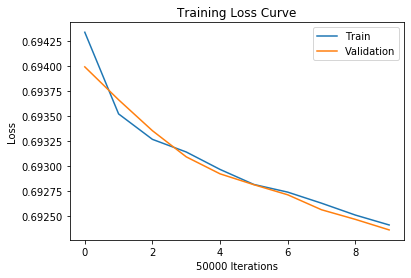

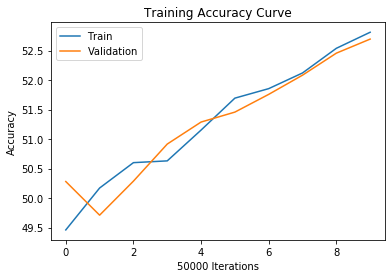

Training Accuracy at epoch 0: 52.81
Validation Accuracy epoch 0: 52.694


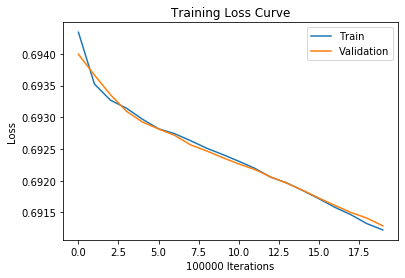

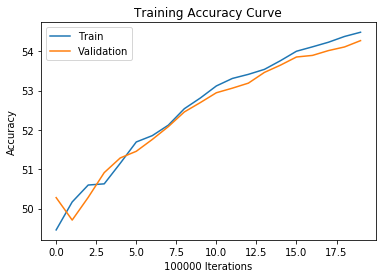

Training Accuracy at epoch 0: 54.48
Validation Accuracy epoch 0: 54.267


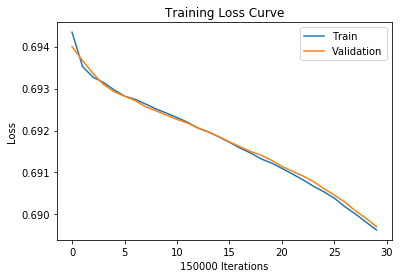

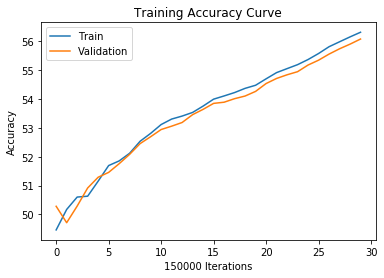

Training Accuracy at epoch 0: 56.32
Validation Accuracy epoch 0: 56.084666666666664


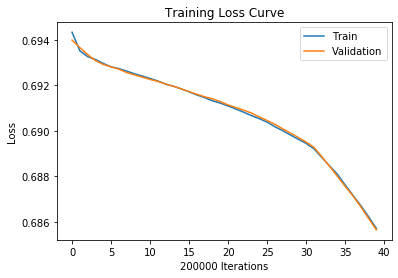

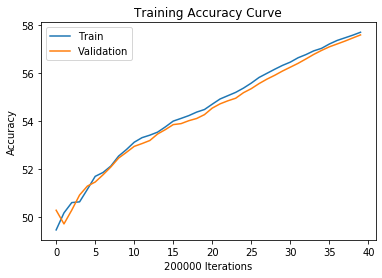

Training Accuracy at epoch 0: 57.7025
Validation Accuracy epoch 0: 57.591


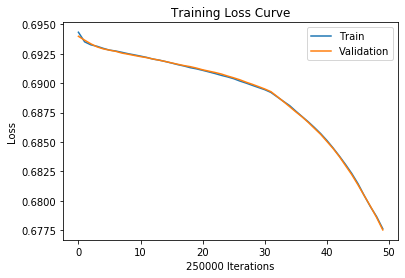

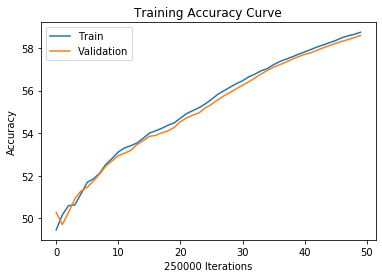

Training Accuracy at epoch 0: 58.7344
Validation Accuracy epoch 0: 58.5828


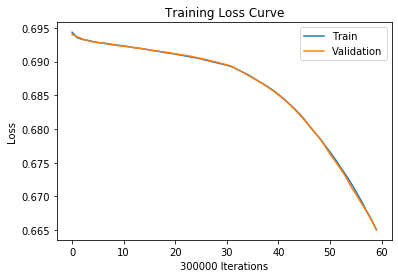

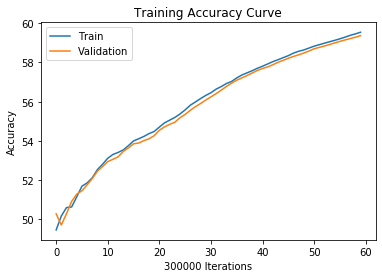

Training Accuracy at epoch 0: 59.54066666666667
Validation Accuracy epoch 0: 59.370333333333335


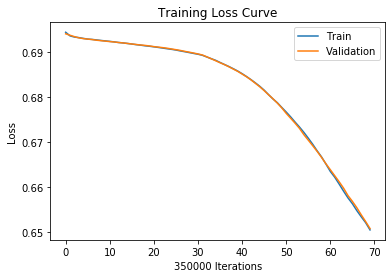

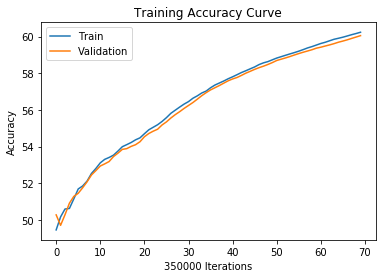

Training Accuracy at epoch 0: 60.238
Validation Accuracy epoch 0: 60.05285714285714


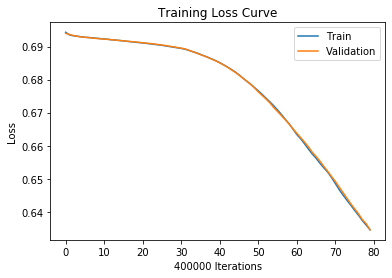

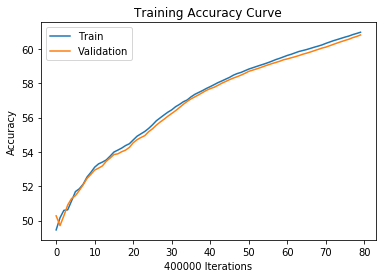

Training Accuracy at epoch 0: 60.976
Validation Accuracy epoch 0: 60.81825


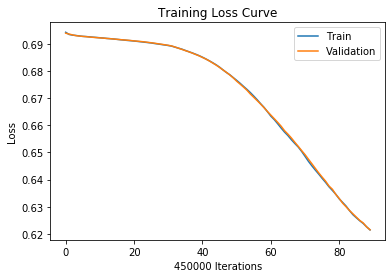

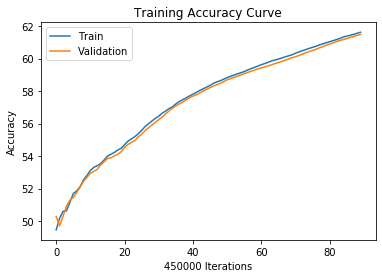

Training Accuracy at epoch 0: 61.61888888888889
Validation Accuracy epoch 0: 61.48088888888889


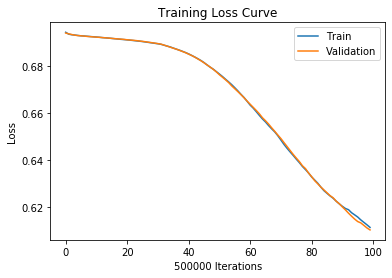

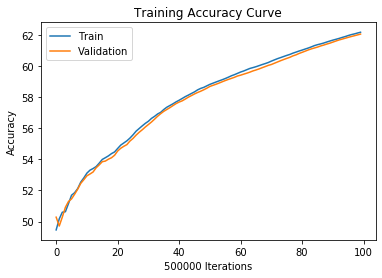

Training Accuracy at epoch 0: 62.186
Validation Accuracy epoch 0: 62.0664


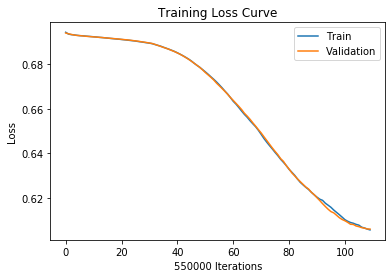

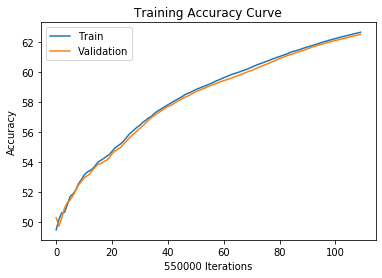

Training Accuracy at epoch 0: 62.659454545454544
Validation Accuracy epoch 0: 62.513636363636365


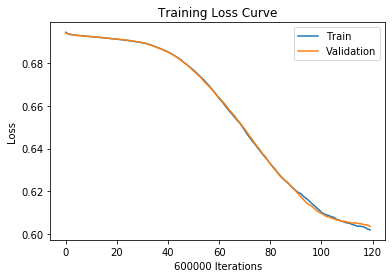

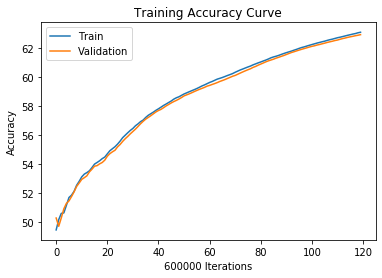

Training Accuracy at epoch 0: 63.0855
Validation Accuracy epoch 0: 62.9195


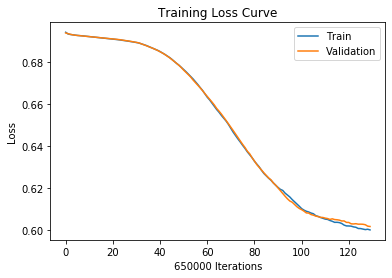

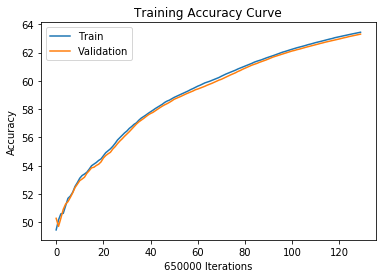

Training Accuracy at epoch 0: 63.43876923076923
Validation Accuracy epoch 0: 63.305076923076925


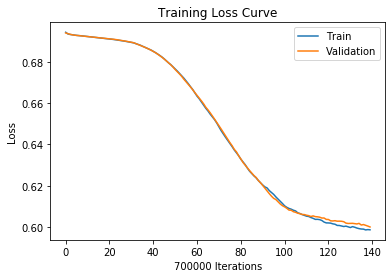

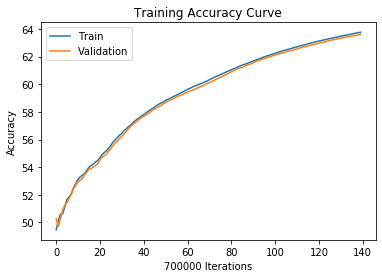

Training Accuracy at epoch 0: 63.75857142857143
Validation Accuracy epoch 0: 63.61071428571429


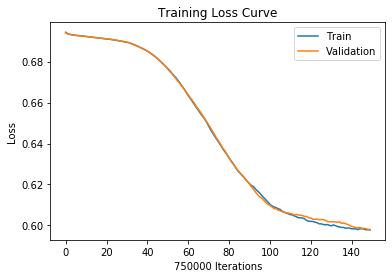

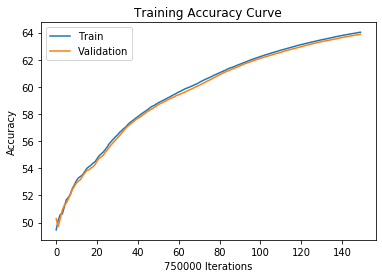

Training Accuracy at epoch 0: 64.02893333333333
Validation Accuracy epoch 0: 63.8836


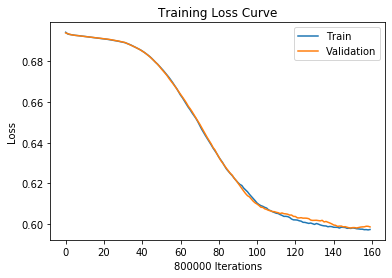

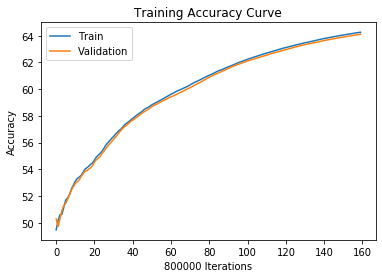

Training Accuracy at epoch 0: 64.263875
Validation Accuracy epoch 0: 64.1155


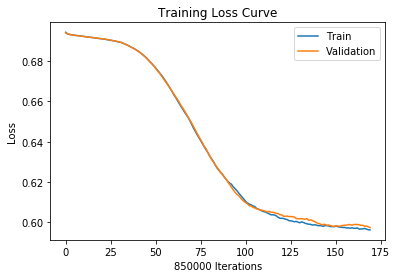

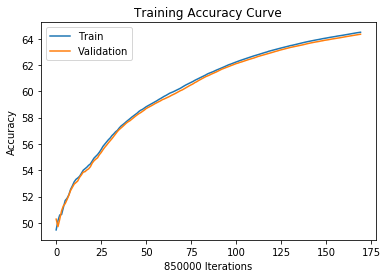

Training Accuracy at epoch 0: 64.49717647058823
Validation Accuracy epoch 0: 64.34705882352941


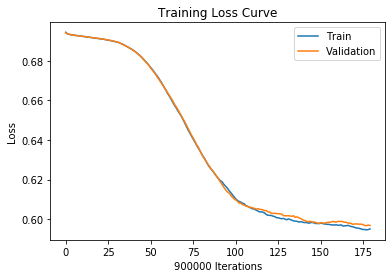

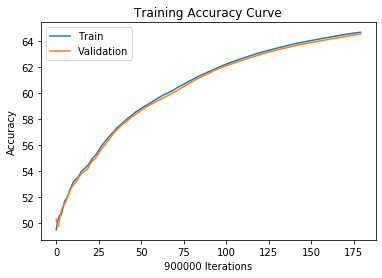

Training Accuracy at epoch 0: 64.693
Validation Accuracy epoch 0: 64.55522222222223
Saving to:  model_checkpoints/binary/LinearConv1d/05072020.pth
Starting epoch: 1  with learning rate:  [0.005]


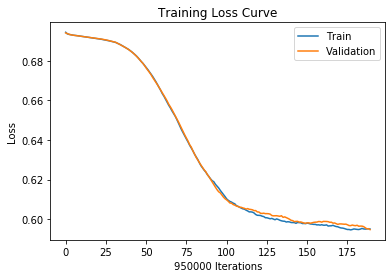

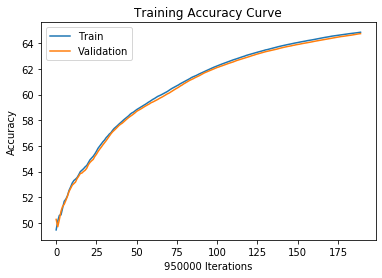

Training Accuracy at epoch 1: 64.85631578947368
Validation Accuracy epoch 1: 64.74863157894737


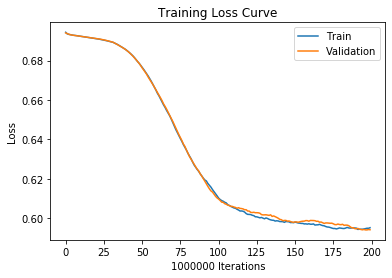

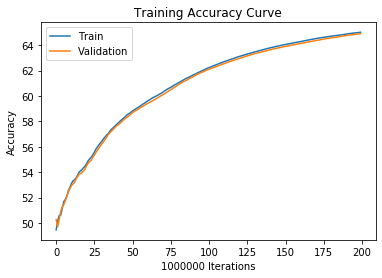

Training Accuracy at epoch 1: 65.0172
Validation Accuracy epoch 1: 64.9033


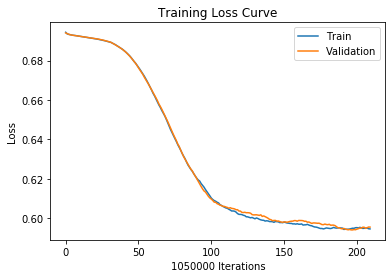

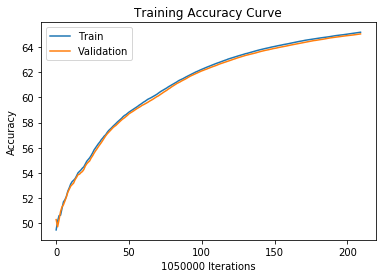

Training Accuracy at epoch 1: 65.18561904761904
Validation Accuracy epoch 1: 65.05266666666667


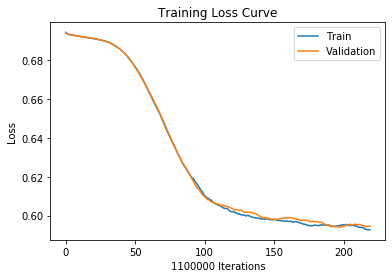

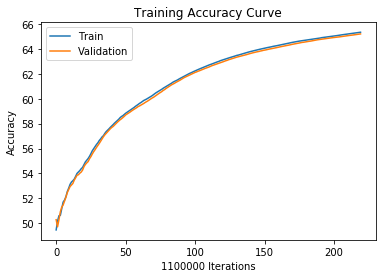

Training Accuracy at epoch 1: 65.33863636363637
Validation Accuracy epoch 1: 65.20290909090909


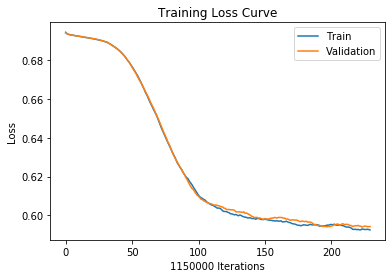

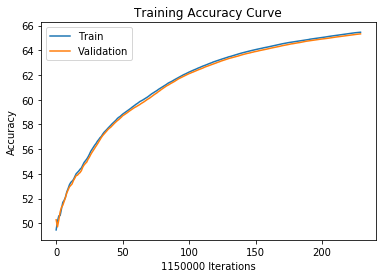

Training Accuracy at epoch 1: 65.46391304347826
Validation Accuracy epoch 1: 65.33130434782609


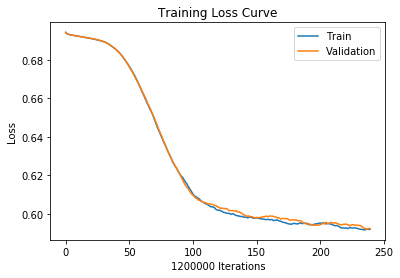

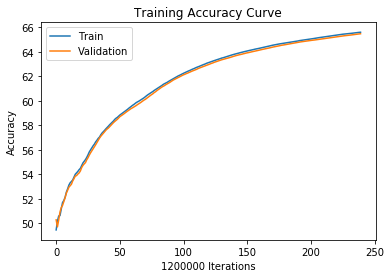

Training Accuracy at epoch 1: 65.58541666666666
Validation Accuracy epoch 1: 65.4625


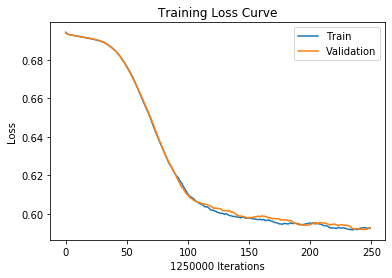

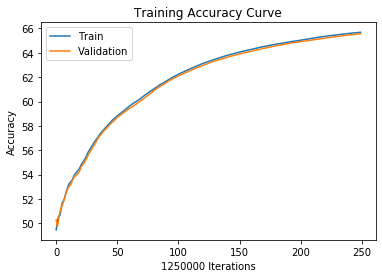

Training Accuracy at epoch 1: 65.68896
Validation Accuracy epoch 1: 65.56392


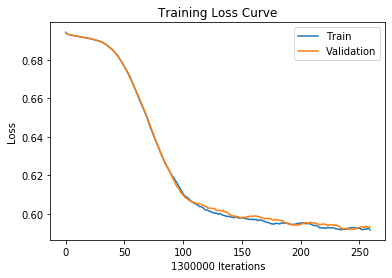

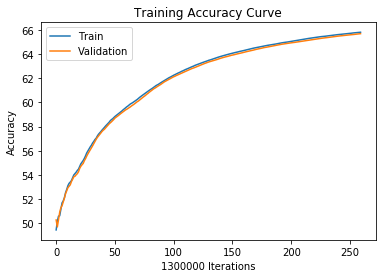

Training Accuracy at epoch 1: 65.79053846153846
Validation Accuracy epoch 1: 65.673


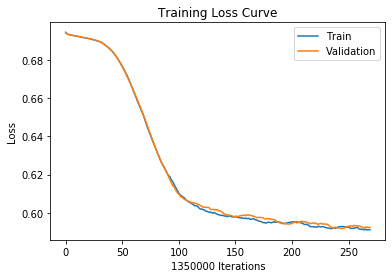

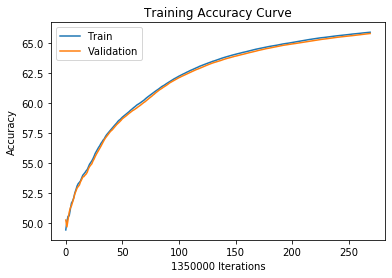

Training Accuracy at epoch 1: 65.88918518518518
Validation Accuracy epoch 1: 65.78503703703704


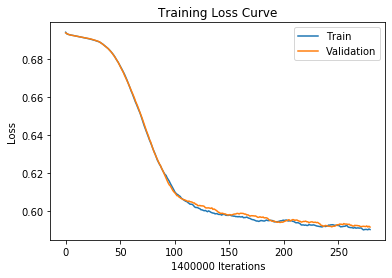

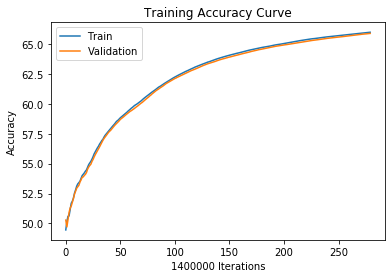

Training Accuracy at epoch 1: 65.9785
Validation Accuracy epoch 1: 65.88121428571428


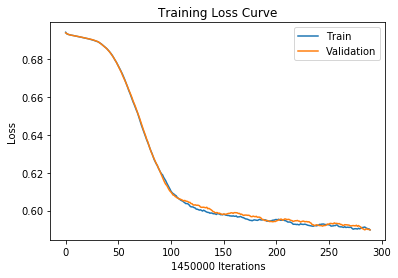

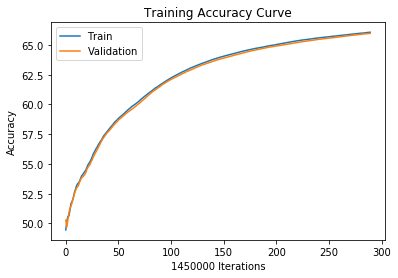

Training Accuracy at epoch 1: 66.07006896551724
Validation Accuracy epoch 1: 65.974


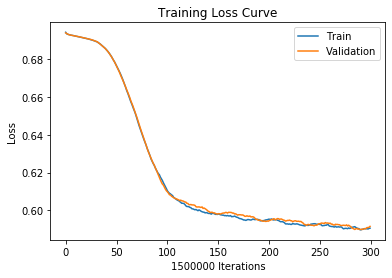

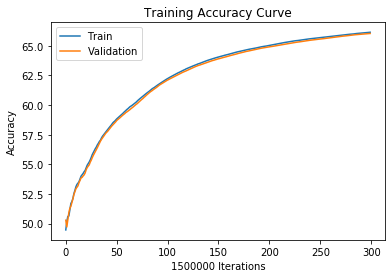

Training Accuracy at epoch 1: 66.1478
Validation Accuracy epoch 1: 66.04426666666667


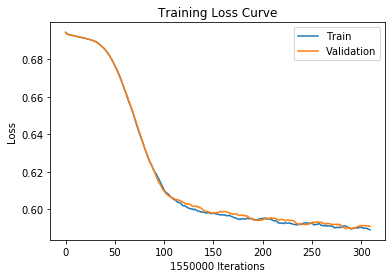

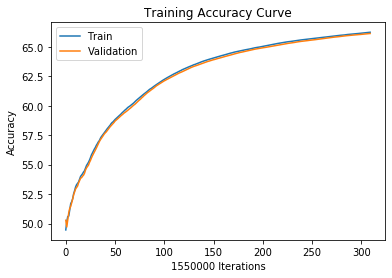

Training Accuracy at epoch 1: 66.23606451612903
Validation Accuracy epoch 1: 66.13025806451613


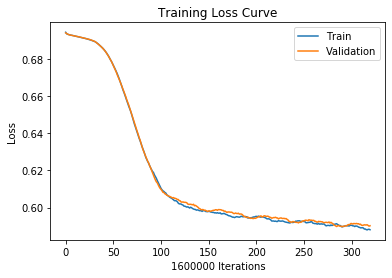

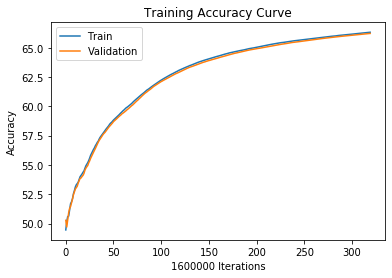

Training Accuracy at epoch 1: 66.318375
Validation Accuracy epoch 1: 66.2176875


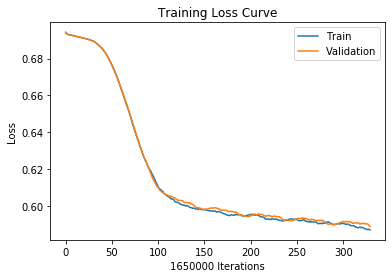

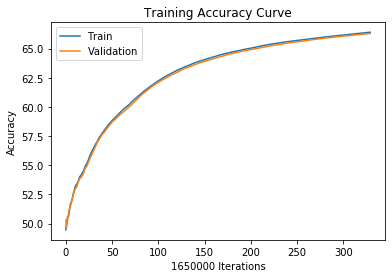

Training Accuracy at epoch 1: 66.39812121212121
Validation Accuracy epoch 1: 66.29339393939394


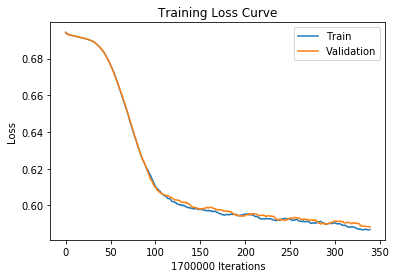

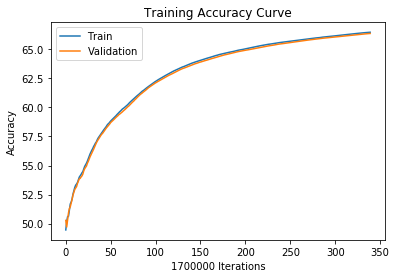

Training Accuracy at epoch 1: 66.466
Validation Accuracy epoch 1: 66.36158823529412


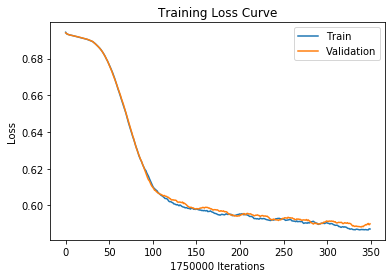

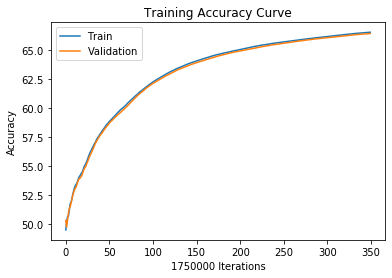

Training Accuracy at epoch 1: 66.52788571428572
Validation Accuracy epoch 1: 66.41697142857143


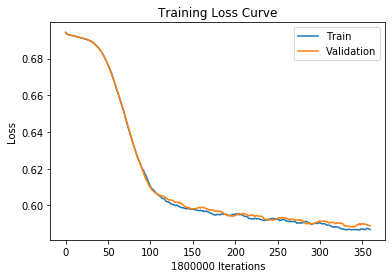

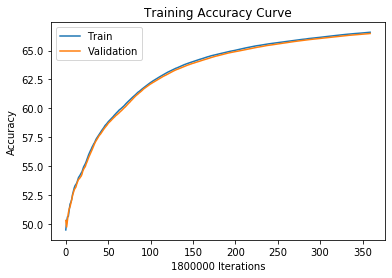

Training Accuracy at epoch 1: 66.59566666666667
Validation Accuracy epoch 1: 66.48805555555556


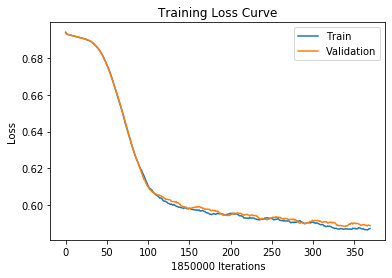

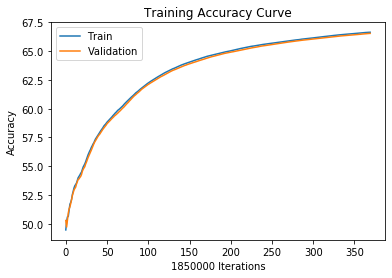

Training Accuracy at epoch 1: 66.64691891891891
Validation Accuracy epoch 1: 66.548
Saving to:  model_checkpoints/binary/LinearConv1d/05072020.pth
Starting epoch: 2  with learning rate:  [0.004050000000000001]


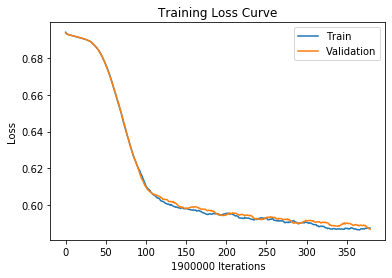

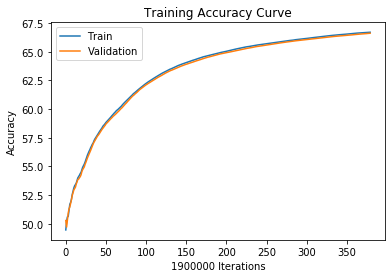

Training Accuracy at epoch 2: 66.69531578947368
Validation Accuracy epoch 2: 66.61031578947369


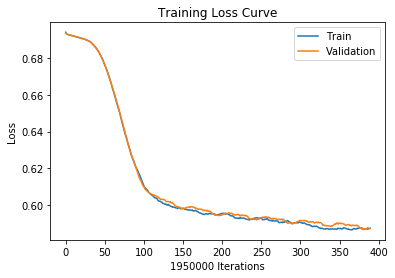

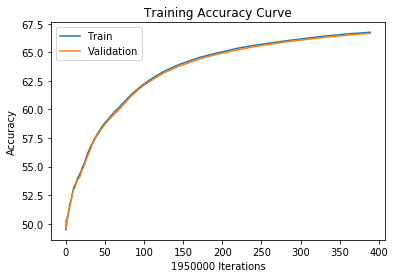

Training Accuracy at epoch 2: 66.74974358974359
Validation Accuracy epoch 2: 66.66


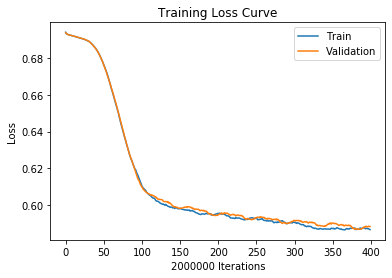

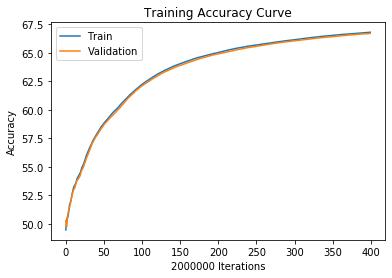

Training Accuracy at epoch 2: 66.8113
Validation Accuracy epoch 2: 66.7086


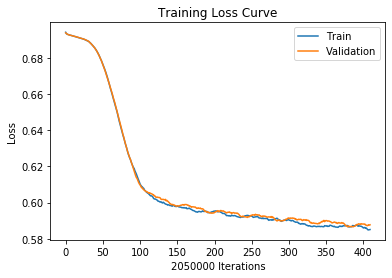

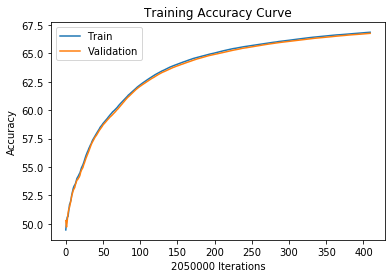

Training Accuracy at epoch 2: 66.86253658536586
Validation Accuracy epoch 2: 66.76668292682926


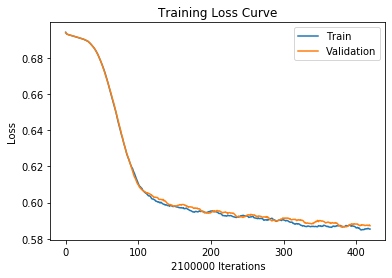

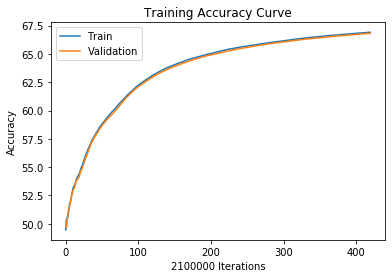

Training Accuracy at epoch 2: 66.91004761904762
Validation Accuracy epoch 2: 66.81766666666667


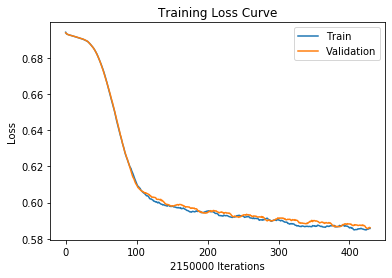

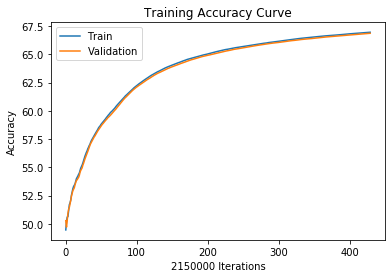

Training Accuracy at epoch 2: 66.95706976744187
Validation Accuracy epoch 2: 66.86488372093024


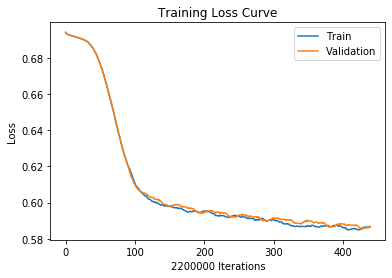

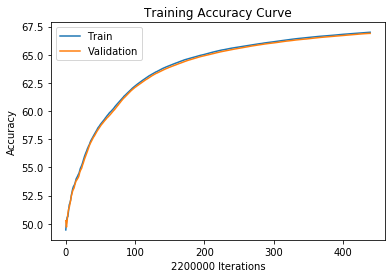

Training Accuracy at epoch 2: 66.99972727272727
Validation Accuracy epoch 2: 66.89895454545454


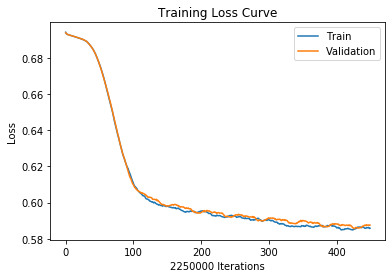

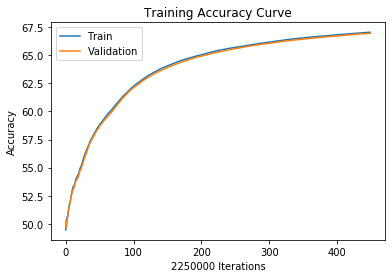

Training Accuracy at epoch 2: 67.03991111111111
Validation Accuracy epoch 2: 66.94417777777778


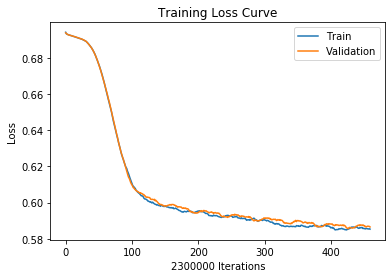

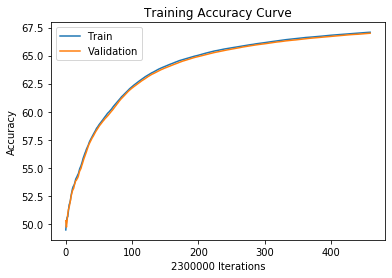

Training Accuracy at epoch 2: 67.08304347826088
Validation Accuracy epoch 2: 66.99421739130435


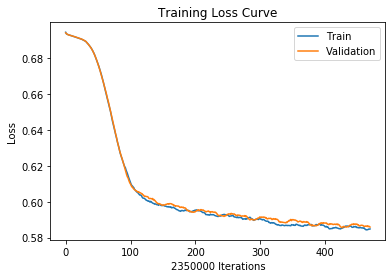

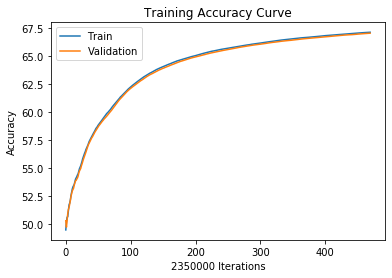

Training Accuracy at epoch 2: 67.12042553191489
Validation Accuracy epoch 2: 67.03587234042553


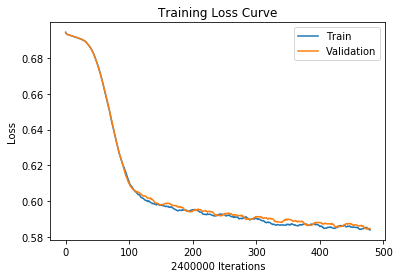

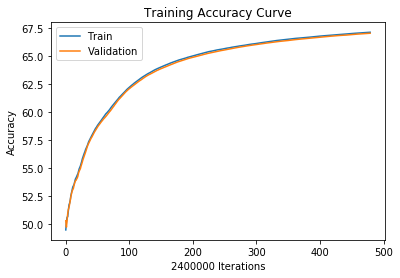

Training Accuracy at epoch 2: 67.16233333333334
Validation Accuracy epoch 2: 67.073125


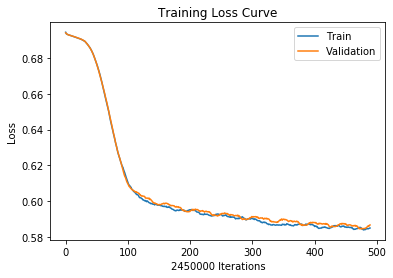

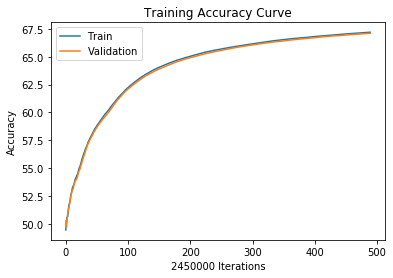

Training Accuracy at epoch 2: 67.20040816326531
Validation Accuracy epoch 2: 67.10648979591836


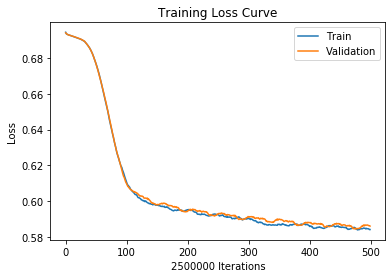

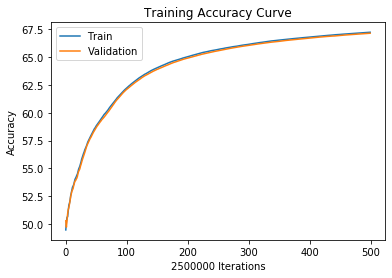

Training Accuracy at epoch 2: 67.24024
Validation Accuracy epoch 2: 67.15088


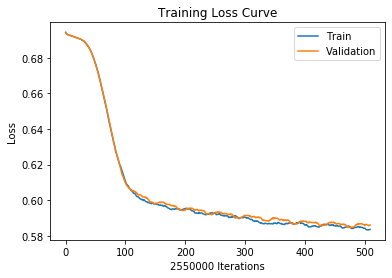

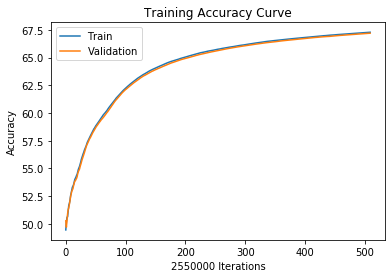

Training Accuracy at epoch 2: 67.27905882352941
Validation Accuracy epoch 2: 67.19309803921568


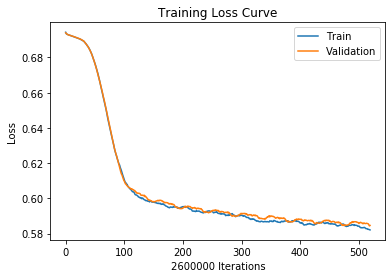

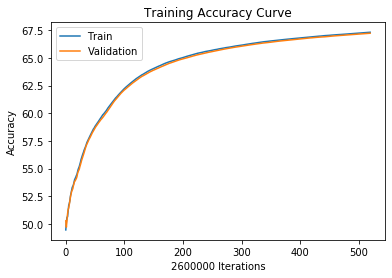

Training Accuracy at epoch 2: 67.32034615384616
Validation Accuracy epoch 2: 67.23057692307692


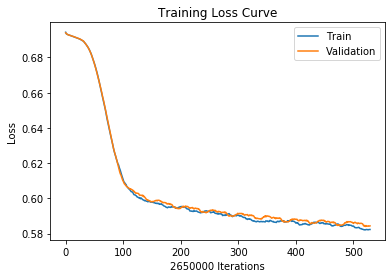

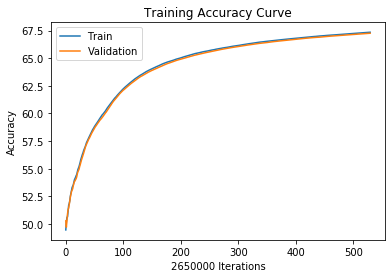

Training Accuracy at epoch 2: 67.35233962264151
Validation Accuracy epoch 2: 67.26245283018868


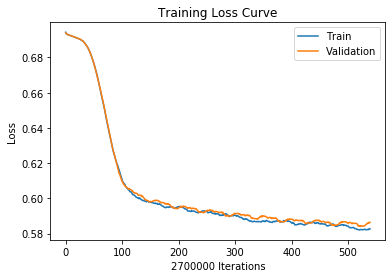

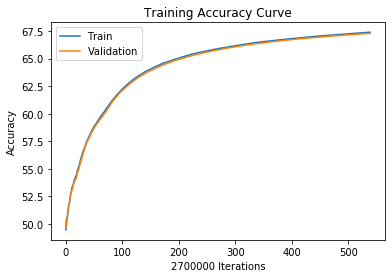

Training Accuracy at epoch 2: 67.38681481481481
Validation Accuracy epoch 2: 67.29222222222222


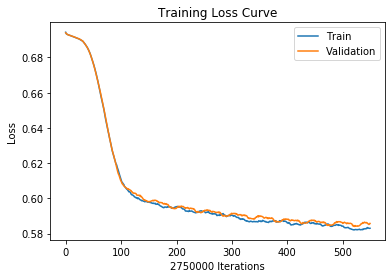

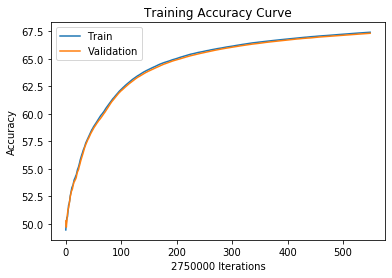

Training Accuracy at epoch 2: 67.4222909090909
Validation Accuracy epoch 2: 67.32854545454545


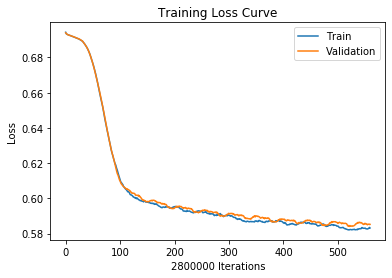

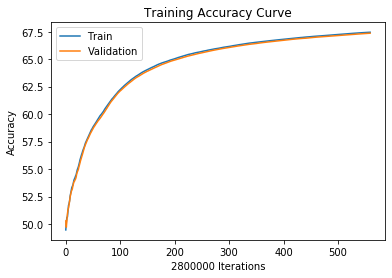

Training Accuracy at epoch 2: 67.44696428571429
Validation Accuracy epoch 2: 67.36007142857143
Saving to:  model_checkpoints/binary/LinearConv1d/05072020.pth
Starting epoch: 3  with learning rate:  [0.0045000000000000005]


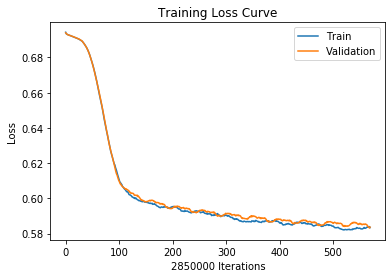

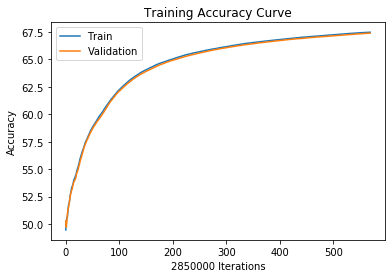

Training Accuracy at epoch 3: 67.47305263157895
Validation Accuracy epoch 3: 67.39164912280702


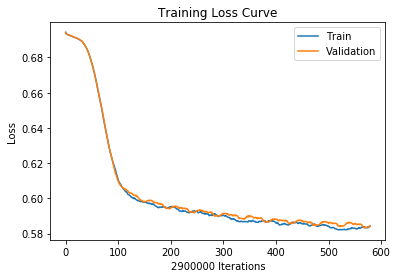

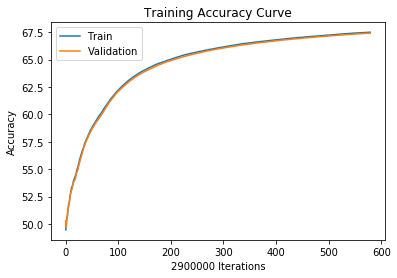

Training Accuracy at epoch 3: 67.50075862068965
Validation Accuracy epoch 3: 67.417


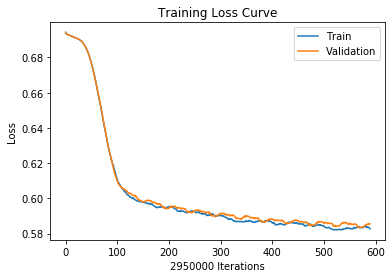

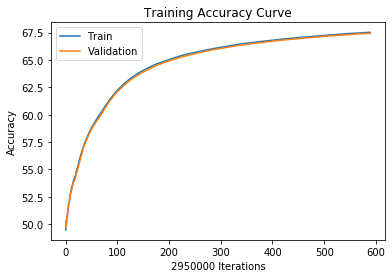

Training Accuracy at epoch 3: 67.53762711864407
Validation Accuracy epoch 3: 67.44298305084746


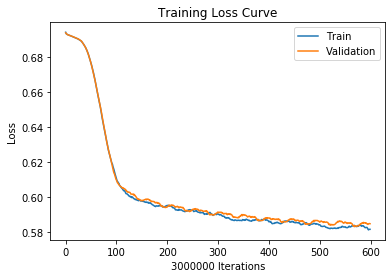

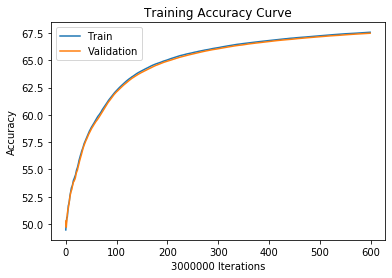

Training Accuracy at epoch 3: 67.56733333333334
Validation Accuracy epoch 3: 67.47653333333334


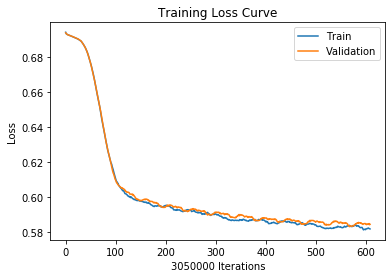

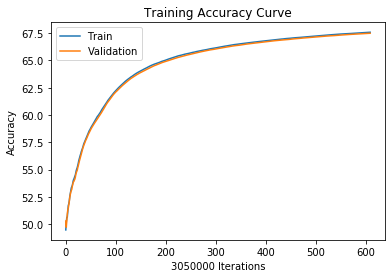

Training Accuracy at epoch 3: 67.59144262295082
Validation Accuracy epoch 3: 67.49940983606557


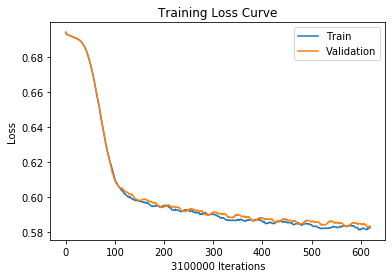

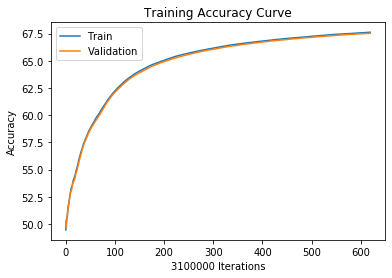

Training Accuracy at epoch 3: 67.61732258064517
Validation Accuracy epoch 3: 67.525


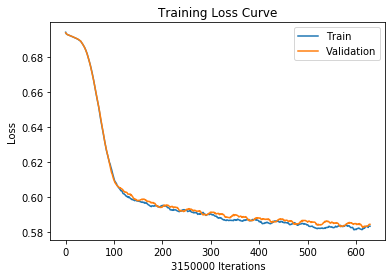

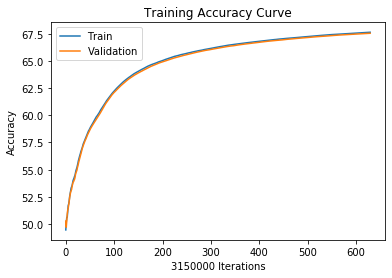

Training Accuracy at epoch 3: 67.63942857142857
Validation Accuracy epoch 3: 67.54577777777777


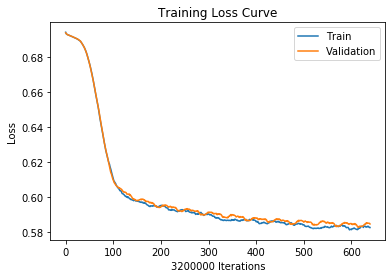

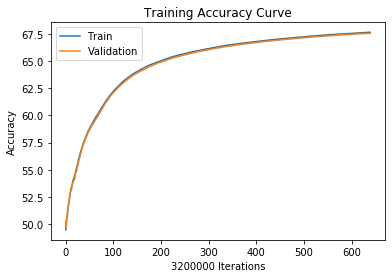

Training Accuracy at epoch 3: 67.66346875
Validation Accuracy epoch 3: 67.57


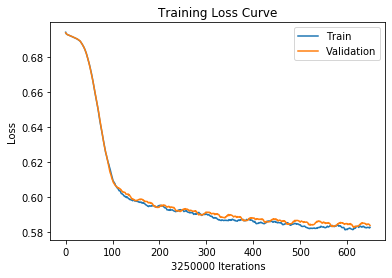

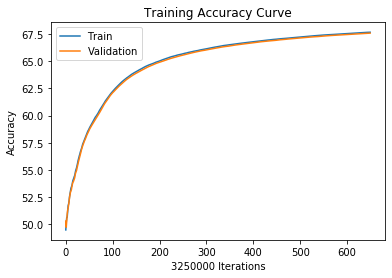

Training Accuracy at epoch 3: 67.68258461538461
Validation Accuracy epoch 3: 67.60067692307692


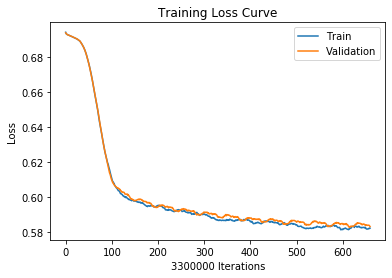

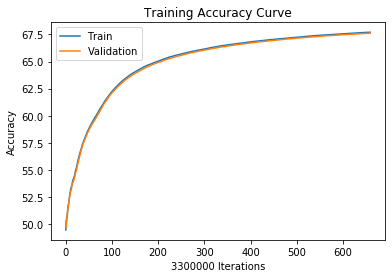

Training Accuracy at epoch 3: 67.705
Validation Accuracy epoch 3: 67.62403030303031


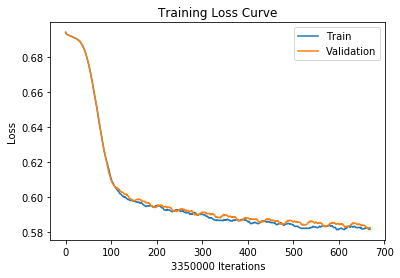

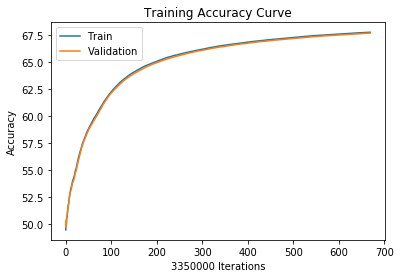

Training Accuracy at epoch 3: 67.72832835820896
Validation Accuracy epoch 3: 67.64617910447761


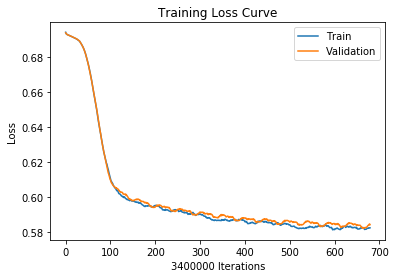

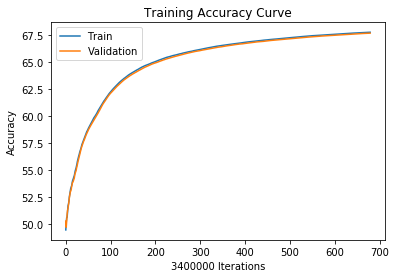

Training Accuracy at epoch 3: 67.74826470588235
Validation Accuracy epoch 3: 67.66394117647059


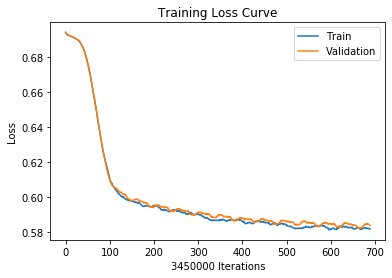

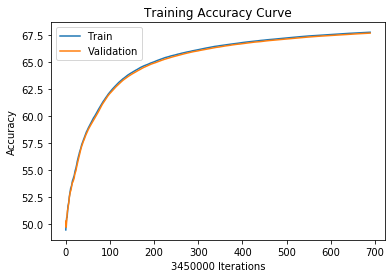

Training Accuracy at epoch 3: 67.77165217391304
Validation Accuracy epoch 3: 67.69011594202898


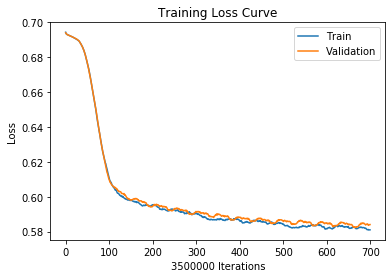

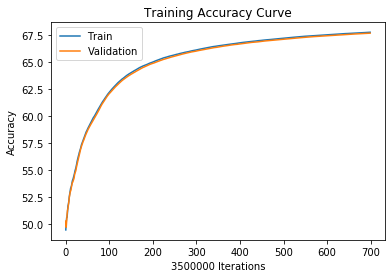

Training Accuracy at epoch 3: 67.79754285714286
Validation Accuracy epoch 3: 67.71157142857143


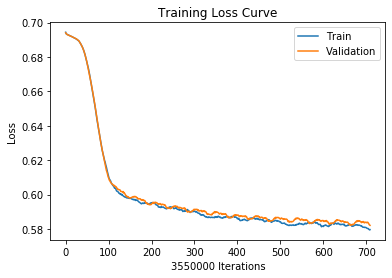

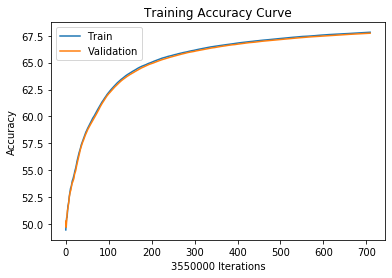

Training Accuracy at epoch 3: 67.82360563380281
Validation Accuracy epoch 3: 67.7338028169014


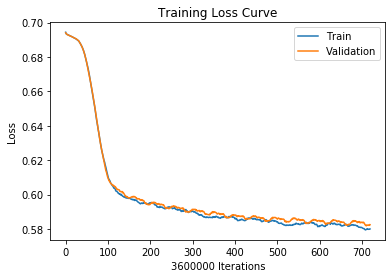

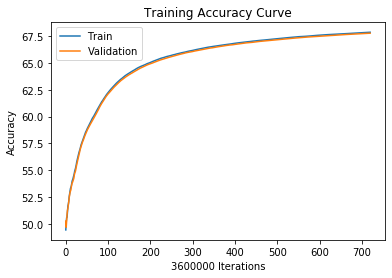

Training Accuracy at epoch 3: 67.84213888888888
Validation Accuracy epoch 3: 67.75194444444445


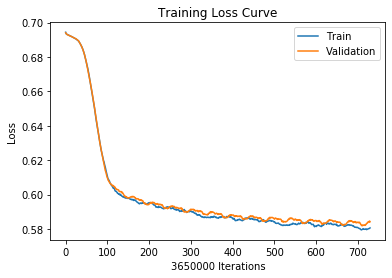

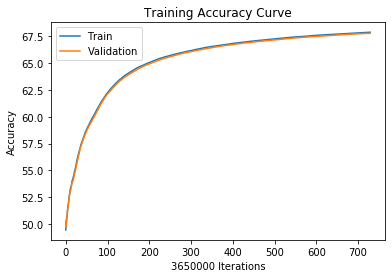

Training Accuracy at epoch 3: 67.8607397260274
Validation Accuracy epoch 3: 67.76854794520548


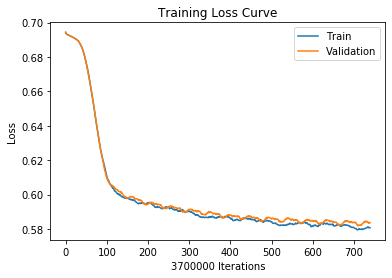

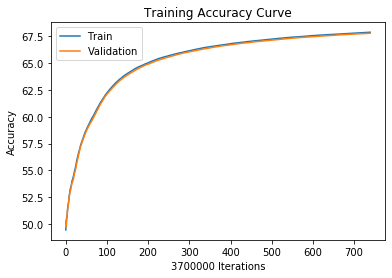

Training Accuracy at epoch 3: 67.88416216216216
Validation Accuracy epoch 3: 67.79248648648648


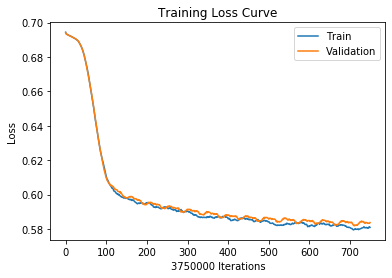

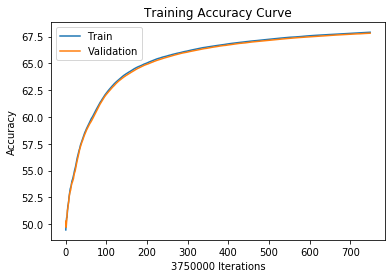

Training Accuracy at epoch 3: 67.89936
Validation Accuracy epoch 3: 67.80970666666667
Saving to:  model_checkpoints/binary/LinearConv1d/05072020.pth
Starting epoch: 4  with learning rate:  [0.0045000000000000005]


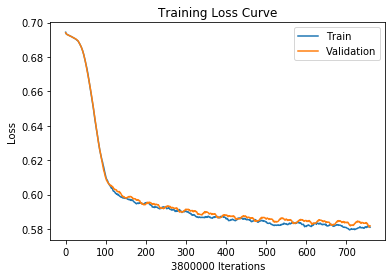

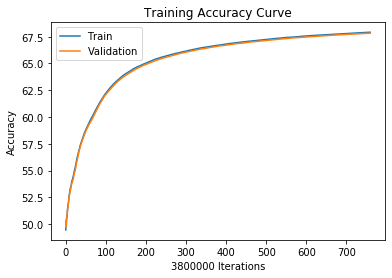

Training Accuracy at epoch 4: 67.91592105263157
Validation Accuracy epoch 4: 67.83026315789473


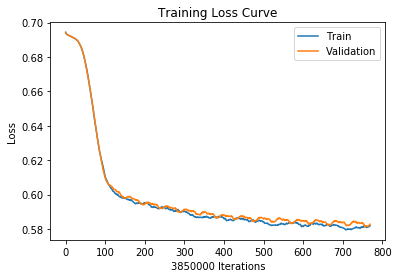

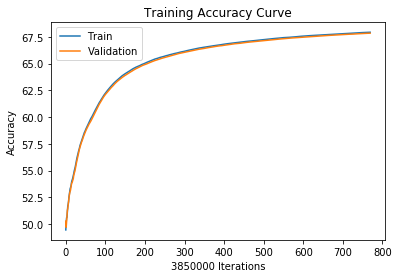

Training Accuracy at epoch 4: 67.93262337662338
Validation Accuracy epoch 4: 67.84472727272727


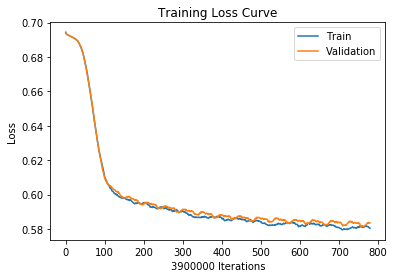

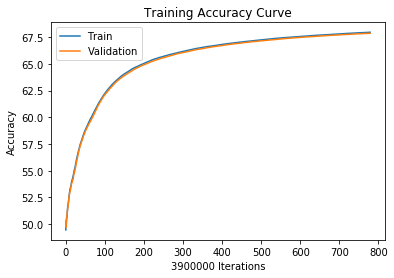

Training Accuracy at epoch 4: 67.95669230769231
Validation Accuracy epoch 4: 67.86261538461538


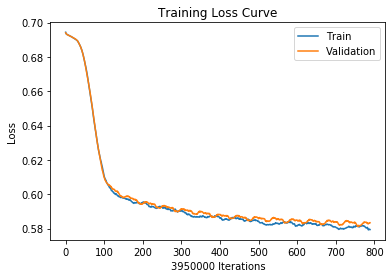

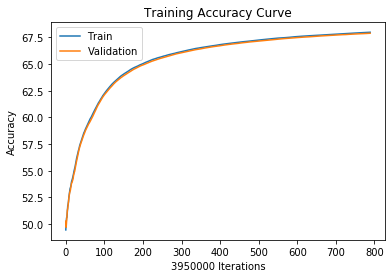

Training Accuracy at epoch 4: 67.97691139240506
Validation Accuracy epoch 4: 67.88402531645569


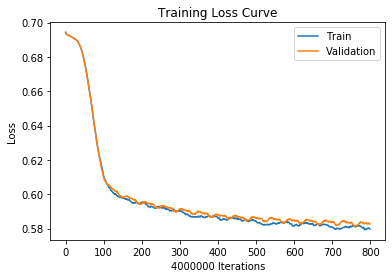

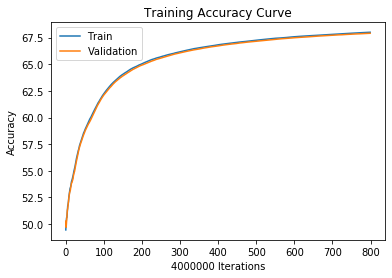

Training Accuracy at epoch 4: 67.994075
Validation Accuracy epoch 4: 67.8985


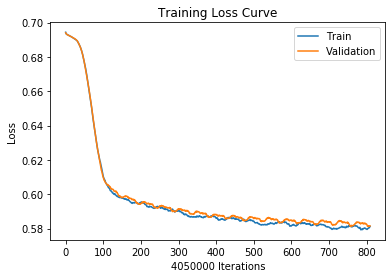

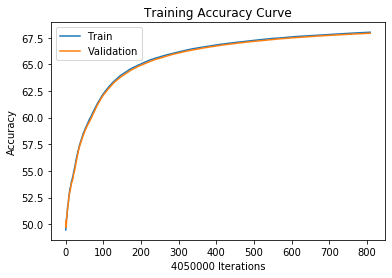

Training Accuracy at epoch 4: 68.00837037037037
Validation Accuracy epoch 4: 67.91604938271605


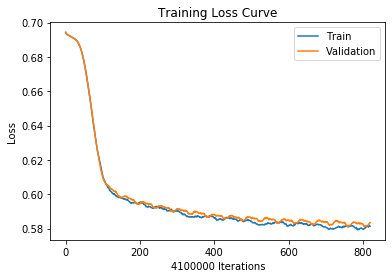

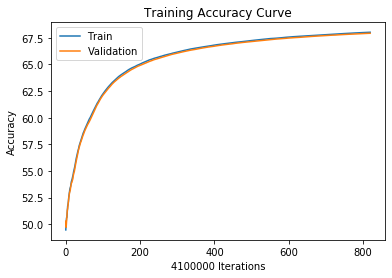

Training Accuracy at epoch 4: 68.02339024390244
Validation Accuracy epoch 4: 67.92651219512194


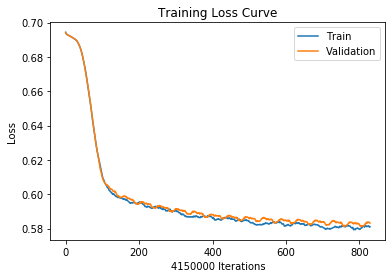

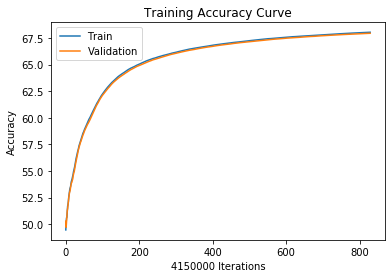

Training Accuracy at epoch 4: 68.04012048192772
Validation Accuracy epoch 4: 67.94373493975904


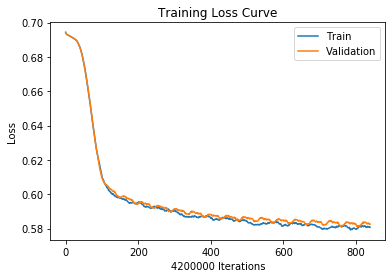

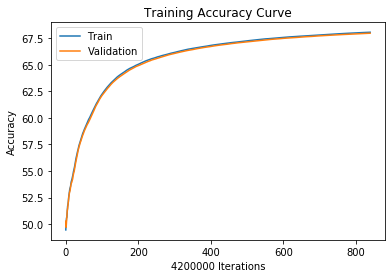

Training Accuracy at epoch 4: 68.05321428571429
Validation Accuracy epoch 4: 67.96240476190476


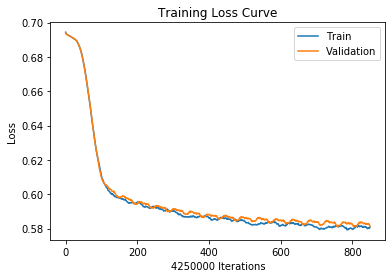

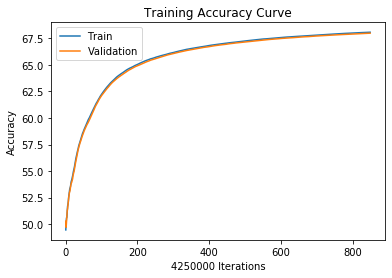

Training Accuracy at epoch 4: 68.06691764705883
Validation Accuracy epoch 4: 67.97941176470589


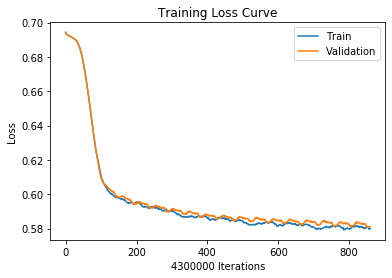

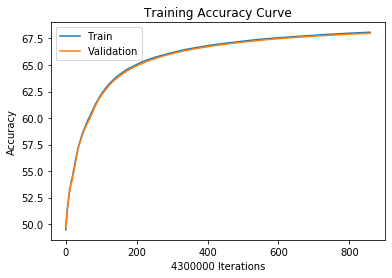

Training Accuracy at epoch 4: 68.08358139534884
Validation Accuracy epoch 4: 67.99230232558139


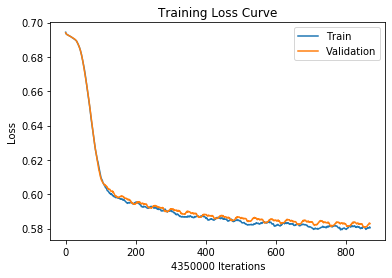

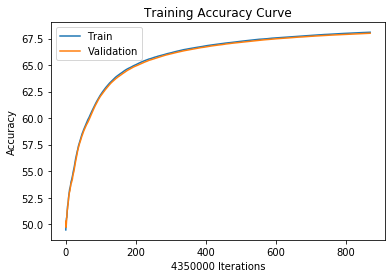

Training Accuracy at epoch 4: 68.09712643678161
Validation Accuracy epoch 4: 68.00335632183908


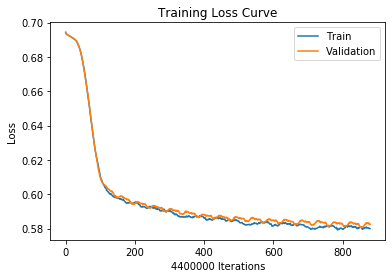

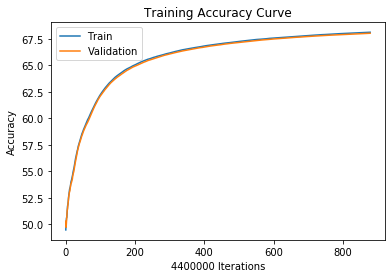

Training Accuracy at epoch 4: 68.11438636363637
Validation Accuracy epoch 4: 68.02013636363637


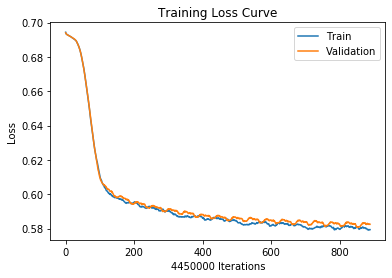

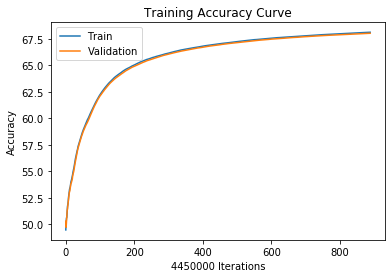

Training Accuracy at epoch 4: 68.13173033707865
Validation Accuracy epoch 4: 68.03539325842696


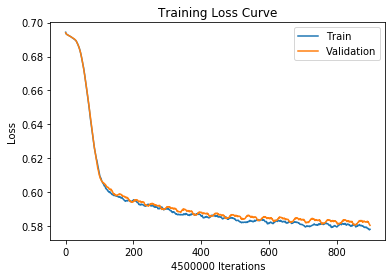

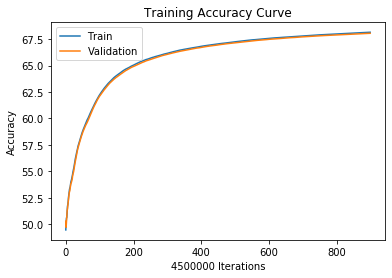

Training Accuracy at epoch 4: 68.14904444444444
Validation Accuracy epoch 4: 68.05088888888889


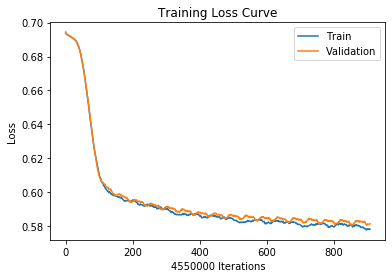

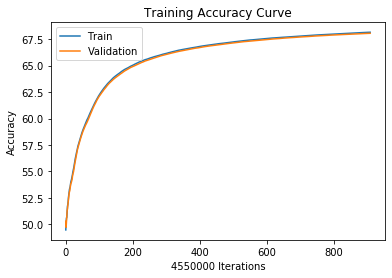

Training Accuracy at epoch 4: 68.16114285714286
Validation Accuracy epoch 4: 68.06303296703297


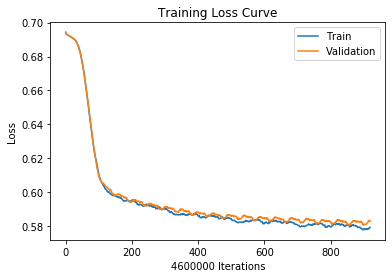

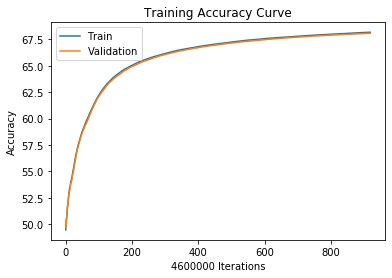

Training Accuracy at epoch 4: 68.17576086956522
Validation Accuracy epoch 4: 68.07443478260869


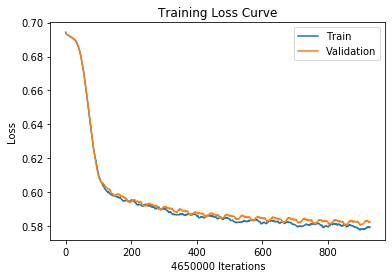

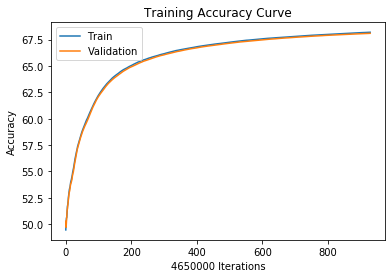

Training Accuracy at epoch 4: 68.19146236559139
Validation Accuracy epoch 4: 68.0908817204301


In [ ]:
model = LinearConv1d()
model_name = model.name
model.to(device)
checkpoint = None
save_path = 'model_checkpoints/binary/%s/05072020.pth' %model_name
NUM_EPOCHS = 100
BATCH_SIZE = 32
classifier(model, binary_train, binary_val, NUM_EPOCHS, BATCH_SIZE, checkpoint, save_path)